In [3]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (1beba54e) has not changed since last install.
  Use `force = TRUE` to force installation



---
# Trends in obs

## GMST only

In [107]:
varnm = "tx5x"
datasets <- c("CPC", "ERA5", "MSWX")

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

models <- sapply(datasets, function(ds) {
    ts <- load_ts(paste0("ts_obs/Americas-heatwave_",varnm,"_",ds,".dat"), col.names = c("year", varnm))
    df <- merge(gmst, ts)
    
    fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
}, simplify = F)

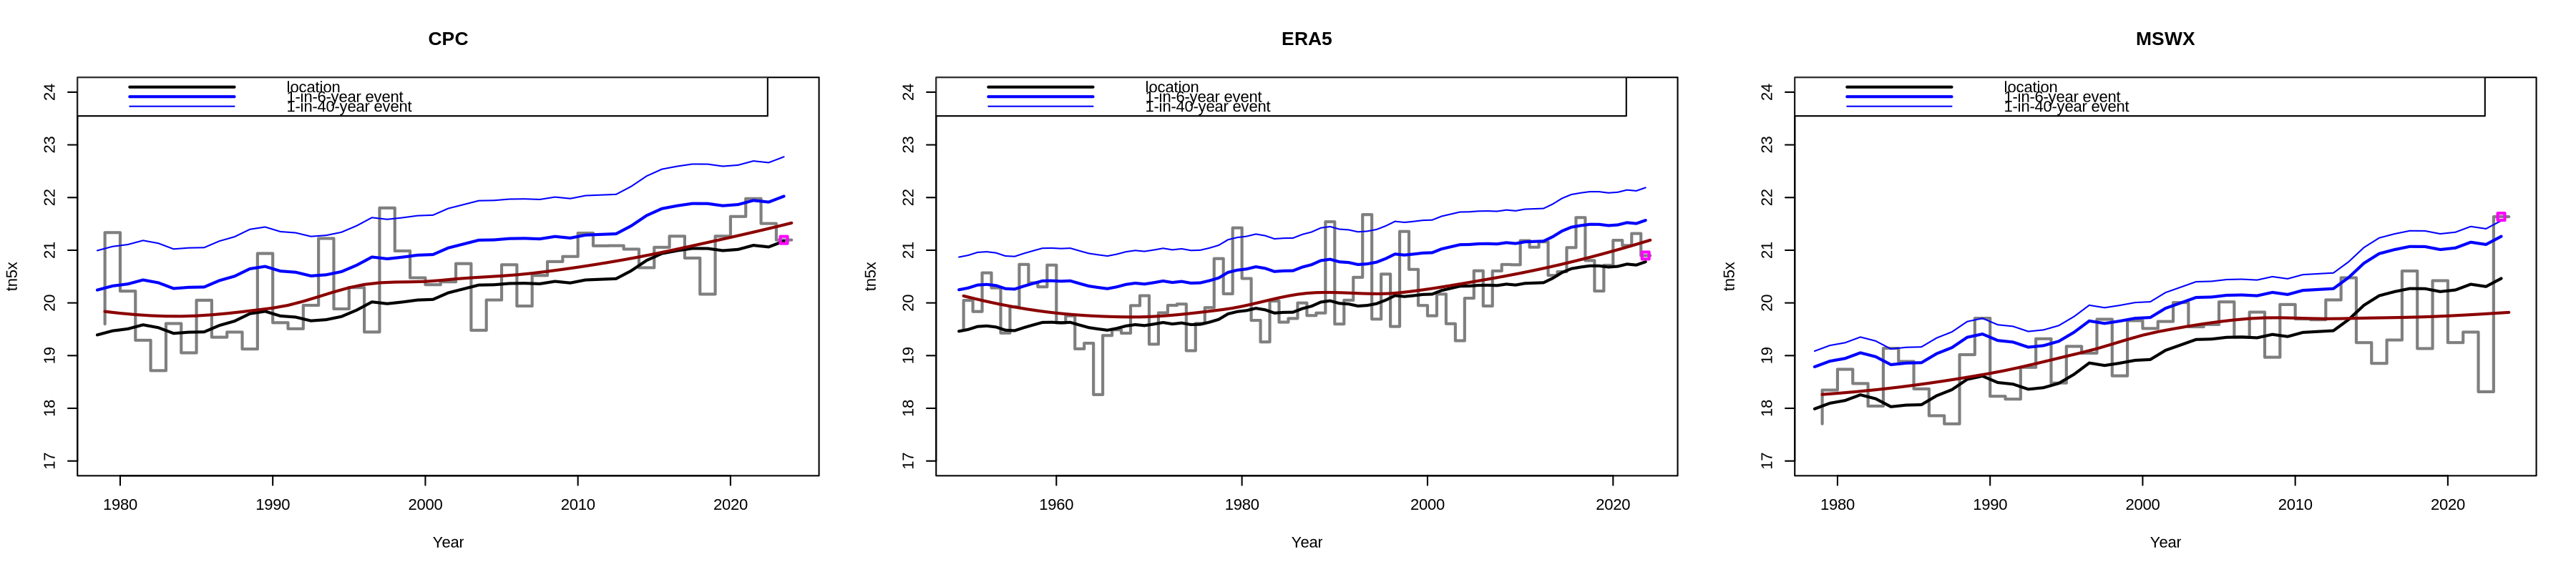

In [108]:
prep_window(c(1,3), w = 6)

if(varnm == "tx5x") {ylim <- c(30,38)} else {ylim <- c(17,24)}

for (ds in datasets) {
    mdl <- models[[ds]]
    plot_trend(mdl, ylim = ylim, main = ds)
    lines(mdl$data$year, fitted(loess(formula(paste0(varnm, "~ year")), mdl$data)), col = "darkred", lwd = 2, xlab = "")
#     lines(mdl$data$year, filter(mdl$data[,varnm], rep(1/15,15), sides = 2), col = "darkgreen", lwd = 2)
}

## GMST + Nino

In [109]:
varnm = "tn5x"
datasets <- c("CPC", "ERA5", "MSWX")

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

nino <- read.csv("data/nino_3monthly.csv")

models <- sapply(colnames(nino)[-1], function(ns) {
                 sapply(datasets, function(ds) {
                     ts <- load_ts(paste0("ts_obs/Americas-heatwave_",varnm,"_",ds,".dat"), col.names = c("year", varnm))
                     df <- merge(merge(gmst, ts), nino)
                     
                     fit_ns("gev", "shift", df, varnm, c("gmst", ns), lower = F)
                }, simplify = F)
            }, simplify = F)

models[["gmst"]] <- sapply(datasets, function(ds) {
    ts <- load_ts(paste0("ts_obs/Americas-heatwave_",varnm,"_",ds,".dat"), col.names = c("year", varnm))
    df <- merge(gmst, ts)
    
    fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
}, simplify = F)

In [110]:
sapply(models, sapply, aic)

,djf,jfm,fma,mam,gmst
CPC,93.00788,92.66184,92.15132,91.38746,92.85391
ERA5,138.54419,138.49553,138.47009,138.48481,136.56941
MSWX,96.25902,96.42732,96.82309,97.09922,95.12556


In [111]:
prep_window(c(5,3), w = 4, h = 2.5, mar = c(2,2,3,1))

if(varnm == "tx5x") {ylim <- c(30,38)} else {ylim <- c(17,24)}

png(paste0("fig/nino-contribution_",varnm,".png"), height = 150*5, width = 240 * 3); par(mfrow = c(5,3), mar = c(2,2,3,1)); {
    for (ctype in c("gmst", colnames(nino)[-1])) {
        for (ds in datasets) {

            mdl <- models[[ctype]][[ds]]

            if (ctype == "gmst") cstring = "gmst" else cstring = paste0("gmst + nino_",ctype)
            plot_trend(mdl, ylim = ylim, main = paste0(ds, ": ",varnm," ~ ",cstring), legend_pos = NA)
            lines(mdl$data$year, fitted(loess(formula(paste0(varnm, "~ year")), mdl$data)), col = "darkred", lwd = 2, xlab = "")
        #     lines(mdl$data$year, filter(mdl$data[,varnm], rep(1/15,15), sides = 2), col = "darkgreen", lwd = 2)
        }
    }
}; dev.off()

png 
  2

## Bootstrapped results

In [112]:
varnm = "tn5x"
datasets <- c("CPC", "ERA5", "ERA5-1970", "MSWX")

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- gmst[gmst$year == 2024,"gmst",drop = F]
cov_cf <- cov_2024 - 1.2

for (ds in datasets) {
    ts <- load_ts(paste0("ts_obs/Americas-heatwave_",varnm,"_",ds,".dat"), col.names = c("year", varnm))
    df <- merge(gmst, ts)
    
    mdl <- fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
    res <- boot_ci(mdl, cov_2024, cov_cf)
    write.csv(res, paste0("res/res-obs_",varnm,"_",tolower(ds),".csv"))
}

In [113]:
obs_res <- data.frame(t(sapply(datasets, function(ds) {
    res <- read.csv(paste0("res/res-obs_",varnm,"_",tolower(ds),".csv"), row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
})))
write.csv(obs_res, paste0("res-obs_",varnm,".csv"))

## Change since 2000

In [89]:
varnm = "tx5x"
datasets <- c("CPC", "ERA5", "ERA5-1970", "MSWX")

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- gmst[gmst$year == 2024,"gmst",drop = F]
cov_cf <- data.frame(gmst = mean(gmst$gmst[(gmst$year >= 1995) & (gmst$year <= 2005)]))
cov_cf <- cov_2024 - 0.5

# for (ds in datasets) {
round(sapply(datasets, function(ds) {
    ts <- load_ts(paste0("ts_obs/Americas-heatwave_",varnm,"_",ds,".dat"), col.names = c("year", varnm))
    df <- merge(gmst, ts)
    
    mdl <- fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
    c("int_change" = int_change(mdl, cov_f = cov_2024, cov_cf = cov_cf),
      "PR" = prob_ratio(mdl, cov_f = cov_2024, cov_cf = cov_cf),
      "RP_2000" = return_period(mdl, mdl$ev, fixed_cov = cov_cf))
}),2)

,CPC,ERA5,ERA5-1970,MSWX
int_change,0.79,0.59,0.77,0.95
PR,4.35,2.71,4.28,4.69
RP_2000,83.66,43.86,63.07,36.50


## Fitted trend plots

In [114]:
varnm = "tn5x"
datasets <- c("CPC", "ERA5", "ERA5-1970", "MSWX")

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- gmst[gmst$year == 2024,"gmst",drop = F]
cov_cf <- cov_2024 - 1.2

models <- sapply(datasets, function(ds) {
    ts <- load_ts(paste0("ts_obs/Americas-heatwave_",varnm,"_",ds,".dat"), col.names = c("year", varnm))
    df <- merge(gmst, ts)
    
    fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
}, simplify = F)

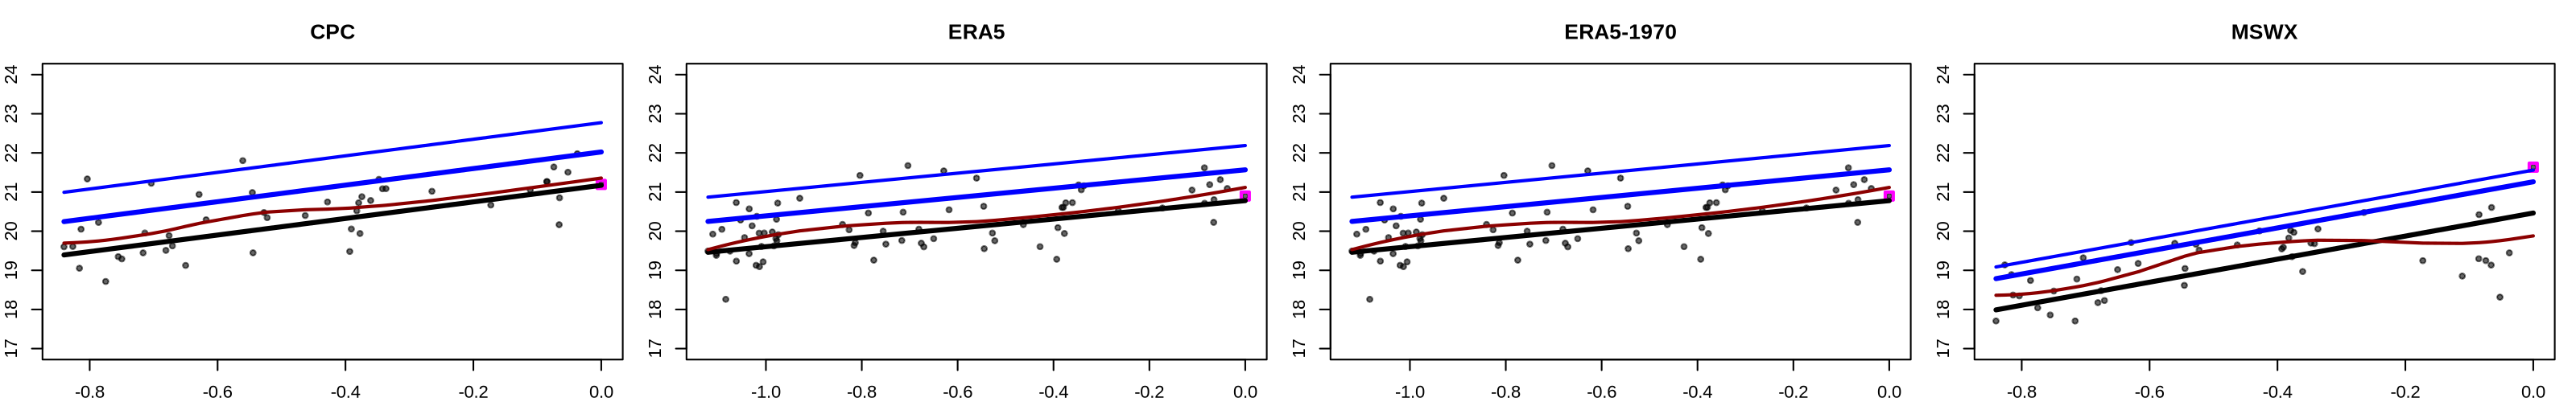

In [115]:
prep_window(c(1,4), w = 4, h = 2.5, mar = c(2,2,3,1))

if(varnm == "tx5x") {ylim <- c(30,38)} else {ylim <- c(17,24)}

for (ds in datasets) {

    mdl <- models[[ds]]
    mdf <- mdl$data[order(mdl$data$gmst),]

    plot_covtrend(mdl, "gmst", ylim = ylim, main = ds, legend_pos = NA, ylab = "")
    lines(mdf$gmst, fitted(loess(formula(paste0(varnm, "~ gmst")), mdf)), col = "darkred", lwd = 2, xlab = "")
}

---
# Fit linear model to gridded data

In [133]:
varnm = "tn5x" 

gmst = read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2024,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - c(1.2,0,0))

In [134]:
fl = list.files("data/flattened", pattern = varnm, full.names = T)
for(fnm in fl) {
    
    res_fnm <- gsub("flattened", "gridded-res", fnm)
    
    if (!file.exists(res_fnm)) {
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # fit nonstationary model to all grid cells
        models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                fit_ns("gev", "shift", df_c, cnm, c("gmst"), lower = F)
            }, error = function(cond) { return(NULL) })
        }, simplify = F)

        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2024, cov_cf = cov_cf)
            } else {
                rep(NA, 10)
            }})
        write.csv(fitted_res, res_fnm)
    }
}

# Trends in climate models

## CORDEX

In [91]:
nsamp = 1000

varnm <- "tx5x"

rp = switch(varnm, "tx5x" = 15, "tn5x" = 2)

# REMO2015 & CRCM5 cut corner off study region so can be excluded
fl <- list.files("ts_cordex", pattern = varnm, full.names = T)
fl <- fl[!grepl("CRCM5", fl)]
fl <- fl[!grepl("REMO2015", fl)]

In [92]:
for (fnm in fl) {
    
    mnm <- paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][4:7]), collapse = "_")
    
    # one run keeps crashing, so skipping for now
    if(mnm %in% c('CAM-22_CNRM-CERFACS-CNRM-CM5_r1i1p1_CRCM5', 'CAM-22_NCC-NorESM1-M_r1i1p1_REMO2015',
                  'CAM-44_IPSL-IPSL-CM5A-MR_r1i1p1_RCA4', 'CAM-44_MOHC-HadGEM2-ES_r1i1p1_RegCM4-3',
                  'CAM-44_MPI-M-MPI-ESM-MR_r1i1p1_RegCM4-3')) next
    
    gmst_fnm <- list.files("ts_cordex", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][5],"_rcp85_",substr(strsplit(fnm, "_")[[1]][6],1,2)), full.names = T)
    if(length(gmst_fnm) == 0) {
        cat("GMST missing:", mnm)
        next
    }
    
    # load data & combine all covariates with time series
    df <- merge(load_ts(fnm, col.names = c("year", varnm)), load_ts(gmst_fnm, col.names = c("year", "gmst")))
    mdl <- fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
    res_fnm <- paste0("res/res-cordex_",varnm,"_",mnm,".csv")
    
    if(!file.exists(res_fnm)) {
        
        # use model's 2023 GMST & observed Nino to define factual climate        
        cov_now <- df[df$year == 2024,"gmst",drop = F]
        cov_hist <- cov_now - 1.2
        cov_fut <- cov_now + 0.8

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        write.csv(res, res_fnm)
    }
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = mnm)
        }; dev.off()
    }
}

GMST missing: CAM-44_MOHC-HadGEM2-ES_r2i1p1_RegCM4-3

In [104]:
# compile results
res <- t(sapply(list.files("res", pattern = paste0("cordex_", varnm), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(3,4,6)], collapse = "_")))
write.csv(res, paste0("res-cordex_",varnm,".csv"))

## HighResMIP

In [105]:
nsamp = 1000

varnm <- "tn5x"

rp = switch(varnm, "tx5x" = 15, "tn5x" = 2)

# currently no Nino data for EC-EARTH
fl <- list.files("ts_highresmip", pattern = varnm, full.names = T)

In [36]:
for (fnm in fl) {
    
    mnm <- gsub(".dat", "", strsplit(fnm, "_")[[1]][4])
    
    gmst_fnm <- list.files("ts_highresmip", pattern = paste0("GSAT-smoothed_highresmip_", mnm, "_"), full.names = T)
    if(length(gmst_fnm) == 0) {
        cat("GMST missing:", mnm)
        next
    }
    
    # load data & combine all covariates with time series
    df <- merge(load_ts(fnm, col.names = c("year", varnm)), load_ts(gmst_fnm, col.names = c("year", "gmst")))
    mdl <- fit_ns("gev", "shift", df, varnm, "gmst", lower = F)
    res_fnm <- paste0("res/res-highresmip_",varnm,"_",mnm,".csv")
    
    if(!file.exists(res_fnm)) {
        
        # use model's 2023 GMST & observed Nino to define factual climate        
        cov_now <- df[df$year == 2024,"gmst",drop = F]
        cov_hist <- cov_now - 1.2
        cov_fut <- cov_now + 0.8

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        write.csv(res, res_fnm)
    }
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = mnm)
        }; dev.off()
    }
}

In [106]:
# compile results
res <- t(sapply(list.files("res", pattern = paste0("highresmip_", varnm), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(3)], collapse = "_")))
write.csv(res, paste0("res-highresmip_",varnm,".csv"))

# Synthesis

In [107]:
# function to fill infinite probability ratios
infer_infinite <- function(models_in) {
    
    # split out the columns for easier reference
    est <- est_n <- models_in[,1]
    l <- l_n <- models_in[,2]
    u <- u_n <- models_in[,3]
    
    # relabel where infinite best estimate / upper bound occurs
    mnames <- rownames(models_in)
    mnames <- paste0(mnames, c("*","")[is.finite(est)+1])
    mnames <- paste0(mnames, c("*","")[is.finite(u)+1])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE BEST ESTIMATES / UPPER BOUNDS
    # get upper bound where best estimate is infinite
    u_n[!is.finite(u_n)] <- (exp(log(est) + 3 * (log(est) - log(l))))[!is.finite(u_n)]

    # get best estimate, if infinite
    if(any(is.finite(u))) {
        # if any estimated upper bounds are finite, use the maximum upper bound to infer infinite best estimates
        f_upper <- max(u[is.finite(u)])
    } else {
        # otherwise, use the maximum inferred upper bound to infer infinite best estimates
        f_upper <- max(u_n[is.finite(u_n)])
    }
    est_n[!is.finite(est_n)] <- f_upper

    # repeat estimation of upper bound using inferred best estimate
    u_n[!is.finite(u_n)] <- (exp(log(est_n) + 3 * (log(est_n) - log(l))))[!is.finite(u_n)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE LOWER BOUNDS NOT YET IMPLEMENTED

    return(data.frame("est" = est_n, "lower" = l_n, "upper" = u_n, row.names = mnames))   
}

In [168]:
varnm <- "tn5x"

models_in <- read.csv(paste0("res-models_",varnm,".csv"), row.names = "X")
models_in <- models_in[models_in$Include == "Y",]

In [169]:
obs_in <- read.csv(paste0("res-obs_",varnm,".csv"), row.names = "X")
obs_in <- obs_in[!rownames(obs_in) == "ERA5-1970",]

In [170]:
synth_dI_attr <- synthesis(obs_in[,grepl("dI.abs", colnames(obs_in))], models_in[,grepl("attr_dI.abs", colnames(models_in))])
synth_dI_proj <- synthesis(obs = NA, models_in[,grepl("proj_dI.abs", colnames(models_in))])

In [171]:
synth_PR_attr <- synthesis(infer_infinite(obs_in[,grepl("PR", colnames(obs_in))]),
                           infer_infinite(models_in[,grepl("attr_PR", colnames(models_in))]), synth_type = "PR")
synth_PR_proj <- synthesis(obs = NA, models_in[,grepl("proj_PR", colnames(models_in))], synth_type = "PR")

In [172]:
# save everything as .csv for easier plotting in Python
for(a in c("dI", "PR")) for (b in c("attr", "proj")) {
    s <- paste0("synth_",a,"_",b)
    write.csv(get(s)$df, paste0("synthesis/",s,"_",varnm,".csv"), row.names = F)
}

In [174]:
models_in[,grepl("proj_PR", colnames(models_in))]

,proj_PR_est,proj_PR_lower,proj_PR_upper
,<dbl>,<dbl>,<dbl>
ACCESS-CM2,1.960784,1.644737,2.331002
ACCESS-ESM1-5,1.964637,1.652893,2.364066
CanESM5,1.956947,1.666667,2.369668
CMCC-ESM2,1.972387,1.683502,2.433090
EC-Earth3,1.893939,1.663894,2.217295
EC-Earth3-Veg,1.930502,1.647446,2.242152
EC-Earth3-Veg-LR,1.930502,1.709402,2.283105
FGOALS-g3,1.897533,1.607717,2.247191
INM-CM4-8,1.960784,1.466276,2.710027
